## 📦 Carga de librerías y configuración inicial

En esta sección se importan las librerías necesarias para el análisis de datos, la generación de imágenes y la interacción con la API de OpenAI. También se configura la lectura de variables de entorno para proteger la clave de acceso a la API.

- `pandas`: para manipulación y análisis de datos tabulares.
- `dotenv`: para cargar la clave de API desde un archivo `.env`.
- `openai`: para interactuar con los modelos de OpenAI.
- `IPython.display`: para mostrar imágenes directamente en la notebook.
- `base64`, `PIL`, `io`: para decodificar y visualizar imágenes generadas por IA.

Además, se verifica que la clave de API esté correctamente configurada antes de continuar.

In [ ]:
import pandas as pd
import os
from dotenv import load_dotenv
from openai import OpenAI
from IPython.display import display
import base64
from PIL import Image
import io
from IPython.display import Markdown, display







load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_KEY:
    print("⚠️ Falta la clave de OpenAI en el archivo .env")


client = OpenAI(api_key=OPENAI_KEY)

## 📂 Carga del dataset y detección de problemas de calidad

En esta sección se carga el archivo `dataset.csv` y se realiza un diagnóstico preliminar de calidad de datos. Se identifican tres tipos de problemas comunes:

- **Valores nulos**: datos faltantes que pueden afectar cálculos o modelos.
- **Duplicados**: registros repetidos que distorsionan estadísticas.
- **Outliers**: valores atípicos detectados mediante el rango intercuartílico (IQR), que pueden indicar errores o casos extremos.

El análisis se aplica únicamente a columnas numéricas (`int64`, `float64`) para detectar outliers de forma robusta. Los resultados se almacenan en variables que luego se utilizarán para generar prompts y visualizaciones.

In [14]:
csv_path = "dataset.csv"   
df = pd.read_csv(csv_path)



nulos = df.isnull().sum().sum()
duplicados = df.duplicated().sum()


outliers = {}
for col in df.select_dtypes(include=["int64", "float64"]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers[col] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()

## 🧠 Diagnóstico automático con IA (Texto → Texto)

En esta etapa se construye un prompt que resume los principales indicadores de calidad del dataset: tamaño, cantidad de valores nulos, duplicados y outliers por columna. El prompt se envía al modelo `gpt-4o-mini` de OpenAI, simulando una consulta a un experto en análisis de datos.

El objetivo es obtener una respuesta breve, clara y estructurada que identifique los problemas y sugiera acciones correctivas. Esta interacción demuestra cómo el prompting puede reemplazar tareas de diagnóstico manual, ahorrando tiempo y estandarizando criterios.

Se utiliza un enfoque de **Fast Prompting**, con instrucciones concisas y bien delimitadas para maximizar la calidad de la respuesta y minimizar el uso de tokens.



🧠 OpenAI responde:

# Reporte de Calidad de Datos

## 1. Interpretación del Estado del Dataset

El dataset analizado cuenta con un total de **5000 registros** y **13 columnas**. Aunque no presenta registros duplicados, lo cual es una buena señal en términos de integridad de datos, se observa la presencia de **888 valores nulos** distribuidos entre las diferentes columnas. Además, ciertos campos presentan un número significativo de **outliers**, especialmente en las columnas relacionadas con ingresos tanto a nivel global como doméstico, lo cual puede indicar problemas de calidad en los datos.

## 2. Problemas Principales

Los problemas que podrían afectar el análisis son los siguientes:

- **Valores Nulos:** Con un total de 888 nulos, es fundamental identificar las columnas más afectadas y evaluar la implicación de estos faltantes en el análisis posterior.
  
- **Outliers:** Las columnas **'$Worldwide'**, **'$Domestic'**, y **'$Foreign'** presentan una cantidad considerable de outliers

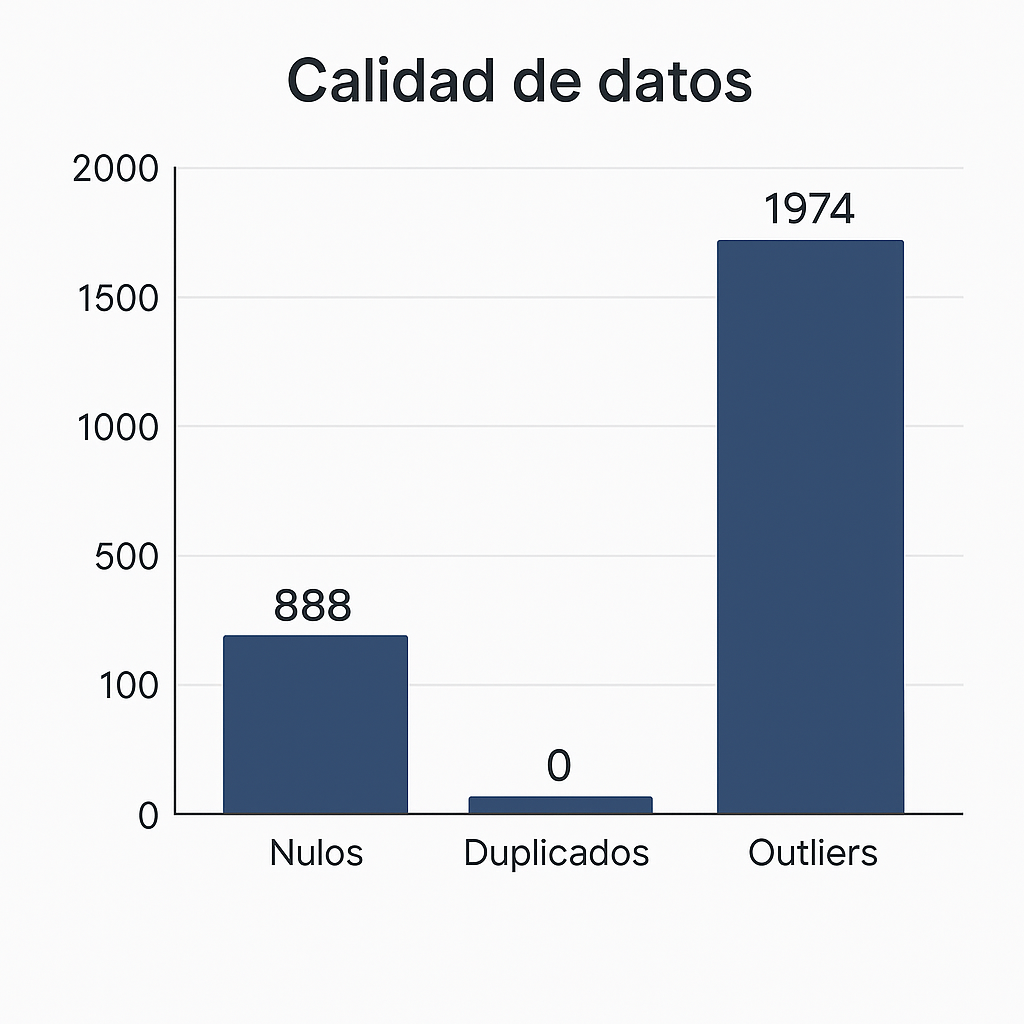

,Problema,Cantidad
0,Nulos,888
1,Duplicados,0
2,Outliers,1974


In [ ]:








# prompt_texto = f"""
# Analiza este dataset y detecta problemas de calidad:
# - Tamaño: {df.shape}
# - Nulos: {nulos}
# - Duplicados: {duplicados}
# - Outliers: {outliers}


# Responde de forma breve y clara, en varios renglones.
# Por ultimo da un breve consejo de que hacer segun como esten esos datos.
# """
prompt_texto = f"""
Eres un experto en calidad de datos. Te paso estadísticas ya calculadas del dataset:

- Registros: {df.shape[0]}
- Columnas: {df.shape[1]}
- Total de nulos: {nulos}
- Total de duplicados: {duplicados}
- Outliers por columna: {outliers}

Con base en estos datos, genera un **reporte en Markdown** que incluya:
1. **Interpretación** del estado del dataset.
2. **Problemas principales** que podrían afectar un análisis.
3. **Recomendaciones prácticas** de limpieza (ej: imputación, eliminación, transformación).
4. **Conclusión final**, breve y en tono profesional.
"""

if OPENAI_KEY:
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Eres un experto en análisis de datos."},
                {"role": "user", "content": prompt_texto}
            ],
            max_tokens=1000
        )
        print("\n🧠 OpenAI responde:\n")
        display(Markdown(response.choices[0].message.content))
    except Exception as e:
        print("❌ Error con OpenAI:", e)



prompt_visual = (
    f"Genera un gráfico de barras que muestre tres problemas de calidad de datos. "
    f"Categorías: 'Nulos' ({nulos}), 'Duplicados' ({duplicados}), 'Outliers' ({sum(outliers.values())}). "
    "Cada barra debe incluir el número exacto encima o dentro de la barra. "
    "El diseño debe ser simple, con etiquetas claras en español, fondo blanco, colores sobrios, "
    "y título 'Calidad de datos'."
)

try:
    result = client.images.generate(
        model="gpt-image-1",
        prompt=prompt_visual,
        size="auto"
    )

    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)

    img = Image.open(io.BytesIO(image_bytes))
    display(img)
    img.save("infografia_calidad.png")
except Exception as e:
    print("❌ Error al generar imagen con OpenAI:", e)


resumen = pd.DataFrame({
    "Problema": ["Nulos", "Duplicados", "Outliers"],
    "Cantidad": [nulos, duplicados, sum(outliers.values())]
})
resumen

